esm based dynamic model (not using static embeds).

+ Use HF Trainer, LORA:
  * https://huggingface.co/blog/AmelieSchreiber/esmbind

Use TF:
*  🇰https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/protein_language_modeling-tf.ipynb#scrollTo=de8419b5
* Torch based /Trainer example:  https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/protein_language_modeling.ipynb#scrollTo=49dcba23



* NOte for pytorch training could use trainer maybe, and mixed precision - https://huggingface.co/docs/transformers/v4.18.0/en/performance#fp16-training


* QLORA finetuning: https://huggingface.co/blog/AmelieSchreiber/esm2-ptm
  * https://huggingface.co/blog/AmelieSchreiber/esmbind   (token level)

* Another lora, qlora example - may use too much mem/bug : https://github.com/huggingface/peft/issues/1023
* Default trainer (`AutoModelForSequenceClassification`) + Lora https://huggingface.co/docs/peft/task_guides/image_classification_lora
   * seq cls with lora - maybe `task_type="SEQ_CLS"` ? https://github.com/huggingface/peft/blob/main/docs/source/task_guides/ptuning-seq-classification.md
* https://www.kaggle.com/code/andregrbnr/protein-sequence-classification - lora modules to save ??

  * ESM2-Lora mem bug (also accel data loop) ? https://github.com/huggingface/peft/issues/1023


* QLORA: https://huggingface.co/blog/AmelieSchreiber/esm2-ptm
  * `36 batch size` with esm-150M !

* lora peft - classifier layer weight saving issue?  https://github.com/huggingface/peft/issues/577

https://github.com/huggingface/transformers/issues/27702


important bug!!!
* https://discuss.huggingface.co/t/llama-2-sequence-classification-much-lower-accuracy-on-inference-from-checkpoint-compared-to-model/54910
* https://github.com/huggingface/transformers/issues/26160
* "What I do know is that the bug does not occur when you don’t specify the target_modules in the LoraConfig, so effectively only use default q & v of the attention blocks."

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !conda install -c conda-forge google-colab -y

# !pip install tensorflow  -U -q # ankh

# !pip install torch  -U -q # fair-esm # seqeval
# !pip3 install transformers peft accelerate datasets evaluate bitsandbytes -U -q # --user
# !pip install peft bitsandbytes -U

* Use the unirpot fasta file I downloaded and uploaded to my drive

`/content/drive/MyDrive/Research/biodata/proteins/Transmembrane_human_90.fasta`

* Download fasta from: `https://www.uniprot.org/uniref/?query=uniprot:(keyword%3A%22Transmembrane+%5BKW-0812%5D%22+AND+organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22)+identity:0.9`

In [3]:
#### DATA_PATH = "/content/drive/MyDrive/Research/CIDR-Protein Anomalies project/protein_anomalies_data/swp_human_viri_all_embed_esm.parquet" ## ESM1B embedding (max len 1022)
# DATA_PATH = "/content/drive/MyDrive/proteins/New Protein-Virus anom project/hum_vir_swp-globalEmbed-train.csv.gz"## TRAIN
# DATA_PATH = "/content/drive/MyDrive/hum_vir_swp-globalEmbed-train.csv.gz"
# DATA_PATH = "/kaggle/input/humvir-proteins/hum_vir_swp-globalEmbed-train.csv/hum_vir_swp-globalEmbed-train.csv"
DATA_PATH = "hum_vir_swp-globalEmbed-train.csv.gz"

## TEST data:
# TEST_DATA_PATH = "/content/drive/MyDrive/proteins/New Protein-Virus anom project/hum_vir_swp-globalEmbed-test.csv.gz"## TRAIN
# TEST_DATA_PATH = "/content/drive/MyDrive/hum_vir_swp-globalEmbed-test.csv.gz"
# TEST_DATA_PATH = "/kaggle/input/humvir-proteins/hum_vir_swp-globalEmbed-test.csv/hum_vir_swp-globalEmbed-test.csv"
TEST_DATA_PATH = "hum_vir_swp-globalEmbed-test.csv.gz"

# ## metadata for all reviewed/swissprot human + virus proteins
# METADATA_PATH = "/content/drive/MyDrive/Research/CIDR-Protein Anomalies project/protein_anomalies_data/SWP_human_viruses_all.xlsx"

TARGET_COL = "virus" ## use for filtering data into 1 class

MAX_LEN = 600#1024#768#530 # exclude sequences longer than this. (Not merely truncate)

FAST_RUN = False#True
SAVE_MODEL = True#False#True

# MODEL_DRIVE_SAVE_PATH = "/content/drive/MyDrive/proteins/New Protein-Virus anom project/trained_esm_lora_trainer_model"
MODEL_DRIVE_SAVE_PATH = "./esm650_lora_trainer_model"#"./esm_lora_trainer_model" #"./esm_lora_trainer_model_sml"
# MODEL_DRIVE_SAVE_PATH   = "./esm150_lora_trainer_model"#"./esm_lora_trainer_model_sml"

# MODEL_DRIVE_SAVE_PATH = "/kaggle/input/humvir-proteins/qlora/qlora" # saved + reuploadedon kaggle

TRAIN_MODEL = True#False
LOAD_TRAINED =  True#True#False# True

# Embed sequences in a FASTA file

In [4]:
import torch
import tensorflow
import tensorflow as tf
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import IsolationForest
# from sklearn.svm import OneClassSVM
from sklearn.preprocessing  import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_predict
# from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
# from sklearn.ensemble import HistGradientBoostingClassifier
from tqdm.autonotebook import tqdm
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, roc_auc_score
from torch import nn
from transformers import TrainingArguments, Trainer, logging
from accelerate import Accelerator
from torch.utils.data.dataloader import DataLoader
## https://huggingface.co/docs/transformers/perf_train_gpu_one

from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AdamWeightDecay
# from tensorflow.keras.optimizers import Adafactor, Adam # more memory effecient than adamWD
# import tensorflow
# from tensorflow.keras.metrics.AUC()
from transformers import AutoTokenizer, EsmForSequenceClassification, Trainer
from transformers import TFAutoModelForSequenceClassification ,TFEsmForSequenceClassification
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModel
from transformers import (
    AutoTokenizer,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
)
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from transformers import AutoTokenizer, BitsAndBytesConfig
from peft import AutoPeftModelForSequenceClassification, AutoPeftModel
from transformers import pipeline

## could use transformer pipeline for inference;
import datasets
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm
from peft import PeftModelForSequenceClassification, get_peft_config
# pipe = pipeline("text-classification", model="facebook/wav2vec2-base-960h", device=0)

2024-03-08 12:50:52.589487: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 12:50:52.605864: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 12:50:52.605885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 12:50:52.606413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 12:50:52.609729: I tensorflow/core/platform/cpu_feature_guar

In [5]:
import wandb
wandb.init(mode="disabled")
# alt 
# wandb.init(project='qlora_humvir')# ; or args = TrainingArguments(report_to="none")

In [6]:
from accelerate import Accelerator
# # Use the accelerator
# ### try disabling? (with qlora)
# # accelerator = Accelerator()# trying this
# # שבבקךקרשאםר צשטנק בשודקד ןדדוקד?
accelerator = Accelerator(mixed_precision="bf16") #bf16") # fp16 # orig used

In [7]:
num_epochs = 4
bch_size = 16#36#32#8#3#2

# opt = Adafactor(3e-4)##AdamWeightDecay(1e-4) #default: AdamWeightDecay(2e-5)
# opt = AdamWeightDecay(5e-4)#(1e-3)
# opt = Adam(8e-4)

if FAST_RUN:
    num_epochs = 1
    # bch_size = 16
    bch_size = 64#32
    MAX_LEN = int(MAX_LEN//1.4)

In [8]:
# model_checkpoint ="facebook/esm2_t6_8M_UR50D"
# model_checkpoint =  "facebook/esm2_t12_35M_UR50D"
# model_checkpoint =  "facebook/esm2_t30_150M_UR50D"
model_checkpoint =  "facebook/esm2_t33_650M_UR50D"

if FAST_RUN:
    model_checkpoint ="facebook/esm2_t6_8M_UR50D"
  # model_checkpoint =  "facebook/esm2_t12_35M_UR50D"


In [9]:
#### df = pd.read_parquet(DATA_PATH) # numpy to pandas
df = pd.read_csv(DATA_PATH,usecols=["Sequence","virus","Length","Cluster name"])
df_test = pd.read_csv(TEST_DATA_PATH,usecols=["Sequence","virus","Length",	"Cluster name"])
 ## lengths of all the seqs

if FAST_RUN:
#   # df.loc[df["Length"]>100]
    df = df.sample(frac=0.1,random_state=4)
    df_test = df_test.sample(frac=0.25,random_state=4)
df

,Sequence,virus,Length,Cluster name
0,MADFLKGLPVYNKSNFSRFHADSVCKASNRRPSVYLPTREYPSEQI...,0,102,Cluster: DET1- and DDB1-associated protein 1
1,MPSTLQVLAKKVLALEHKENDHISREYYYHILKCCGLWWHEAPIIL...,1,362,Cluster: Protein MGF 360-19R
2,MASSAELDFNLQALLEQLSQDELSKFKSLIRTISLGKELQTVPQTE...,0,97,Cluster: Pyrin domain-containing protein 2
3,MAAWGKKHAGKDPVRDECEERNRFTETREEDVTDEHGEREPFAETD...,0,186,Cluster: Protein FAM9B
4,MASDSPARSLDEIDLSALRDPAGIFELVELVGNGTYGQVYKGRHVK...,0,1360,Cluster: TRAF2 and NCK-interacting protein kinase
...,...,...,...,...
20335,MDPDKQDALNSIENSIYRTAFKLQSVQTLCQLDLIDSSLIQQVLLR...,0,578,Cluster: Dystrotelin
20336,MLCPWRTANLGLLLILTIFLVAEAEGAAQPNNSLMLQTSKENHALA...,0,348,Cluster: Cell surface glycoprotein CD200 recep...
20337,MCLRFFSPVPGSTSSATNVTMVVSAGPWSSEKAEMNILEINEKLRP...,0,421,Cluster: Putative neuroblastoma breakpoint fam...
20338,MASHAGQQHAPAFGQAARASGPTDGRAASRPSHRQGASEARGDPEL...,1,376,Cluster: Thymidine kinase


In [10]:
df.groupby(["virus"])["Length"].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
virus,,,,,,,,
0,14668.0,473.16,308.52,11.0,244.0,398.0,623.0,1533.0
1,5672.0,380.31,298.35,11.0,151.0,297.0,514.0,1520.0


In [11]:
print(df["virus"].agg(["mean","sum","count"]).round(2))
df["Length"].describe().round(0)

mean         0.28
sum       5672.00
count    20340.00
Name: virus, dtype: float64


count    20340.0
mean       447.0
std        309.0
min         11.0
25%        213.0
50%        372.0
75%        592.0
max       1533.0
Name: Length, dtype: float64

In [12]:
df_test["Length"].describe().round(1)

count    4777.0
mean      444.3
std       304.5
min        18.0
25%       212.0
50%       369.0
75%       589.0
max      1534.0
Name: Length, dtype: float64

In [13]:
# df = df.loc[df["Length"]<=2*MAX_LEN].reset_index(drop=True)
# df_test = df_test.loc[df_test["Length"]<=2*MAX_LEN].reset_index(drop=True)

print(df["Length"].describe().round(1))
print(df["virus"].agg(["mean","sum","count"]).round(2))

count    20340.0
mean       447.3
std        308.5
min         11.0
25%        213.0
50%        372.0
75%        592.2
max       1533.0
Name: Length, dtype: float64
mean         0.28
sum       5672.00
count    20340.00
Name: virus, dtype: float64


In [14]:
# ## metadata about all sequences, can be used to identify and to define targets/labels
# df_meta = pd.read_excel(METADATA_PATH).dropna(how="all",axis=1)
# df_meta

### example pretrained fb/torch:
* https://github.com/facebookresearch/esm#getting-started-with-this-repo-

* Transformers + trainer example : (mlm case): https://github.com/facebookresearch/esm/discussions/556
* keras models supported / via HF?
  * https://huggingface.co/docs/transformers/model_doc/esm#transformers.EsmForSequenceClassification.forward.example


  TF finetuning example (sequence evel?):
  https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/protein_language_modeling-tf.ipynb#scrollTo=4b26b828

In [15]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AdamWeightDecay
from tensorflow.keras.optimizers import Adafactor, Adam # more memory effecient than adamWD
import tensorflow
# from tensorflow.keras.metrics.AUC()
# from transformers import AutoTokenizer #DataCollatorForLanguageModeling,
## https://huggingface.co/docs/transformers/model_doc/esm#transformers.EsmForSequenceClassification.forward.example
from transformers import AutoTokenizer, EsmForSequenceClassification, Trainer
from transformers import TFAutoModelForTokenClassification, TFAutoModelForSequenceClassification ,TFEsmForSequenceClassification

from peft import prepare_model_for_kbit_training, get_peft_model

In [16]:
ID2LABEL = {
    0: "Human",
    1: "Virus"
}
LABEL2ID = {v: k for k, v in ID2LABEL.items()}

In [17]:
train_sequences = df["Sequence"].tolist()
train_labels = df["virus"].tolist()
train_groups = df["Cluster name"].tolist()

# train_sequences, test_sequences, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.25, shuffle=True)#,stratify=labels)

test_sequences = df_test["Sequence"].tolist()
test_labels = df_test["virus"].tolist()

In [18]:
# !pip3 install bitsandbytes peft -U
 
# !pip install bitsandbytes transformers peft --upgrade --force-reinstall

In [19]:
##https://huggingface.co/docs/peft/main/en/developer_guides/quantization
## lotfQ config - for this, do not initialize as quantized!
# from peft import LoftQConfig, LoraConfig, get_peft_model
# loftq_config = LoftQConfig(loftq_bits=4)

## https://huggingface.co/blog/4bit-transformers-bitsandbytes
# compute_dtype = getattr(torch, "float16")
compute_dtype = getattr(torch, "bfloat16")

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True, # disable to train ok;
  # load_in_8bit=True, # alt
  # bnb_4bit_quant_type="nf4",
   # bnb_4bit_use_double_quant=True,
    # bnb_4bit_compute_dtype=torch.bfloat16,
    # llm_int8_has_fp16_weight =True,
    # llm_int8_threshold = 5.2,
   # bnb_4bit_compute_dtype=compute_dtype
    # ,llm_int8_skip_modules=['classifier',"EsmClassificationHead"] # was enabled? 
)

#########################

# Load ESM-2 model
## smallest: esm2_t6_8M_UR50D
## 2d smallest
## large: esm2_t33_650M_UR50D

 # ElnaggarLab/ankh-base
 ### https://github.com/agemagician/Ankh/blob/main/examples/binary_classification_solubility_task.ipynb - different model?
 #  https://github.com/agemagician/Ankh#models   - 450M model size # model_checkpoint =   "ElnaggarLab/ankh-base"

model_max_len = min(1024,MAX_LEN) # 800

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,
                                          padding= True
#                                           padding= True# alt
                                          ,truncation=True,max_length=model_max_len)

num_labels = max(train_labels + test_labels) + 1  # Add 1 since 0 can be a label
print("Num labels:", num_labels)
##ORIG:
# model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels,problem_type="single_label_classification") # worked, orig

## try this now, alt:
# model = EsmForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
# model = TFEsmForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels,problem_type="single_label_classification")

## https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/protein_language_modeling.ipynb#scrollTo=fc164b49 # uses trainer
##

# model = AutoModelForSequenceClassification. # orig
# model = EsmForSequenceClassification.
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                           problem_type="single_label_classification", # was enabled
                                                           # load_in_4bit=True, # disable to train ok
                                                            # quantization_config=nf4_config,
                                                          #  load_in_8bit=True,  torch_dtype=torch.float32, # try this - new
                                                           # device_map= "cuda:0",#"auto",
                                                           # device_map="auto",
                                                          num_labels=len(ID2LABEL), id2label=ID2LABEL, label2id=LABEL2ID,
                                                            # trust_remote_code=True
                                                           # , from_tf=True,
                                                           # force_download =True,
                                                          )

# last_layer_num = model.num_layers ## 33 for esm2_t33_650M_UR50D
# print(last_layer_num )
model.train()
# model.print_trainable_parameters()

Num labels: 2


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 1280, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-32): 33 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,

In [20]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True) # prepares the whole model for kbit training
# print(model)
# #### model.enable_input_require_grads()

In [21]:
# ## https://github.com/huggingface/transformers/issues/27702

# for name, param in model.named_parameters():
#     # # Freeze all parameters
#     if param.dtype in [torch.float16, torch.float32, torch.float64]:
#     #     param.requires_grad = False

#         # Unfreeze the last two layers in 'layers' and 'score'
#         # if name.startswith('model.layers') and (int(name.split('.')[2]) >= 30):
#         #     param.requires_grad = True
#         # elif name.startswith('score'):
#         #     param.requires_grad = True
#         if name.startswith('class'):
#             print(name,param.requires_grad)
#             param.requires_grad = True

In [22]:
import bitsandbytes as bnb
def find_all_linear_names(model):
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, bnb.nn.Linear4bit):
            names = name.split(".")
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if "lm_head" in lora_module_names:  # needed for 16-bit
        lora_module_names.remove("lm_head")
    return list(lora_module_names)


my_lin_layers = find_all_linear_names(model)
# print(my_lin_layers)

"After we wrap our base model model with PeftModel along with the config, we get a new model where only the LoRA parameters are trainable (so-called “update matrices”) while the pre-trained parameters are kept frozen. These include the parameters of the randomly initialized classifier parameters too. This is NOT we want when fine-tuning the base model on our custom dataset. To ensure that the classifier parameters are also trained, we specify modules_to_save. This also ensures that these modules are serialized alongside the LoRA trainable parameters when using utilities like save_pretrained() and push_to_hub().

In addition to specifying the target_modules within LoraConfig, we also need to specify the modules_to_save. When we wrap our base model with PeftModel and pass the configuration, we obtain a new model in which only the LoRA parameters are trainable, while the pre-trained parameters and the randomly initialized classifier parameters are kept frozen. However, we do want to train the classifier parameters. By specifying the modules_to_save argument, we ensure that the classifier parameters are also trainable, and they will be serialized alongside the LoRA trainable parameters when we use utility functions like save_pretrained() and push_to_hub()."

* `task_type= "SEQ_CLS"` - breaks - RuntimeError: only Tensors of floating point dtype can require gradients

In [23]:
model_checkpoint

'facebook/esm2_t33_650M_UR50D'

In [24]:
## https://huggingface.co/blog/AmelieSchreiber/esmbind
# https://huggingface.co/docs/peft/task_guides/token-classification-lora
### target modules?? https://discuss.huggingface.co/t/esm-2-qlora-gradient-checkpointing-not-compatible/53505/2
## could also set to all linear? 

### https://huggingface.co/docs/peft/task_guides/semantic_segmentation_lora#wrap-the-base-model-as-a-peftmodel-for-lora-training

peft_config = LoraConfig(base_model_name_or_path=model_checkpoint, task_type= TaskType.SEQ_CLS,#"SEQ_CLS",#TaskType.SEQ_CLS, ## disabling helps?? (then get "ValueError: Attempting to unscale FP16 gradients.")
    inference_mode=False, r= 2 if FAST_RUN else 8, # 8, #16,
    lora_alpha=16,
    # lora_dropout=0.05,
    use_rslora = True,
    bias= "all", #"lora_only",#"all", #"lora_only",
    # bias="lora_only",
    # target_modules=my_lin_layers,
    #                      [
    #     "query", "key", "value",
    #     "dense",
    # # "out_proj"
    # ]
    #                 "EsmSelfOutput.dense",
    #         "EsmIntermediate.dense",
    #         "EsmOutput.dense",
    #                 # "word_embeddings",
    #                 # "EsmClassificationHead.dense", ## not sure if works/changes anything
    #                 # "out_proj",
    #                 # "classifier" # fails
    #                 ],
        # target_modules=  target_modules#"all-linear"#modules_list,
           target_modules=  "all-linear" ## causes save score bug; but won't work without this
                         
    # # ### https://www.kaggle.com/code/andregrbnr/protein-sequence-classification
     # ,modules_to_save= # "all-linear",
      # ,modules_to_save=  [ 'EsmClassificationHead.dense','EsmClassificationHead.out_proj']#, 'classifier.out_proj'] # "EsmClassificationHead.dense"
#                       # "classifier",
         # ,modules_to_save= ["EsmClassificationHead"]
      
# #          "pooler",
# # # #                      'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight'
                     # ]
    ## 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight'
    # ,modules_to_save=["classifier"]
                         # ,modules_to_save=[ 'classifier.dense', 'classifier.out_proj']
)

get_peft_model(model, peft_config)

# model = get_peft_model(model, peft_config,mixed=True) # mixed prevents peft save, but othewise, 8bit error?
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 8,226,747 || all params: 660,148,065 || trainable%: 1.2461972451589327


In [25]:
# print(model)
# get_peft_model(model, peft_config)

In [26]:
# # # ## redo here?
# model.gradient_checkpointing_enable()
# model = prepare_model_for_kbit_training(model) # prepares the whole model for kbit training
# # print(model)

In [27]:
## Warning - longer than allowed length - 1024
train_tokenized = tokenizer( train_sequences,  truncation=True,max_length=model_max_len,padding=False) # padding=True,
test_tokenized = tokenizer(test_sequences,  truncation=True,max_length=model_max_len,padding=False) # padding=True,

In [28]:
train_dataset = Dataset.from_dict(train_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

train_dataset = train_dataset.add_column("labels", train_labels)
test_dataset = test_dataset.add_column("labels", test_labels)
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 20340
})

In [29]:
# from accelerate import Accelerator
# # # Use the accelerator
# # ### try disabling? (with qlora)
# # accelerator = Accelerator()# trying this
# # # # accelerator = Accelerator(mixed_precision="fp16") # fp16 # orig used
# model = accelerator.prepare(model)

# train_dataset = accelerator.prepare(train_dataset)
# test_dataset = accelerator.prepare(test_dataset)

With 35M model :
```
Default (1024) max length
batch_size=8

opt = Adafactor(1e-4)##AdamWeightDecay(1e-4) #default: AdamWeightDecay(2e-5)
model.compile(optimizer=opt, metrics=["accuracy"],
              loss="BinaryCrossentropy")
3813/3813 [==============================] - 2625s 661ms/step - loss: 0.2452 - accuracy: 0.9104 - val_loss: 0.1622 - val_accuracy: 0.9363
Epoch 2/3
3813/3813 [==============================] - 2518s 661ms/step - loss: 0.1218 - accuracy: 0.9597 - val_loss: 0.1533 - val_accuracy: 0.9463
Epoch 3/3
3813/3813 [==============================] - 2523s 662ms/step - loss: 0.0730 - accuracy: 0.9799 - val_loss: 0.1978 - val_accuracy: 0.9436

```

In [30]:
from sklearn.metrics import precision_recall_fscore_support,accuracy_score,roc_auc_score
import evaluate

from datasets import load_metric
import torch._dynamo
torch._dynamo.config.suppress_errors = True
    
metric_acc = evaluate.load("accuracy")

metric = evaluate.load("accuracy")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        # 'f1': f1,
        # 'precision': precision,
        # 'recall': recall,
        "roc_auc":roc_auc_score(labels,pred.predictions[:,1])
    }

In [31]:
# ### AttributeError: 'TFEsmForSequenceClassification' object has no attribute 'to'
model_name = model_checkpoint.split("/")[-1]
print(model_name)

training_args = TrainingArguments(
    MODEL_DRIVE_SAVE_PATH, # new output path
    overwrite_output_dir=True,
    # f"{model_name}-finetuned-ft-humVir",
    # f"/content/drive/MyDrive/proteins/New Protein-Virus anom project/t{model_name}-finetuned-humVir",
    per_device_train_batch_size=bch_size,
    # per_device_eval_batch_size=int(1.5*bch_size),
#     gradient_accumulation_steps= 2, #4,
    gradient_checkpointing=True,
    # fp16=True,
    bf16=True, # needs ampere, not supported ?
    tf32=True,
        # torch_compile = True,
    optim = "adamw_8bit", #"paged_adamw_8bit", # adamw_bnb_8bit
    # optim= "adamw_bnb_8bit", #"paged_adamw_8bit",
    label_names = ["labels"],
    learning_rate = 5e-4#2e-4 #5e-3,
    # lr_scheduler_type="cosine",
    ,max_grad_norm = 0.95,
    weight_decay=0.001,
    # eval_accumulation_steps = 2#8
    evaluation_strategy="epoch",
    # warmup_ratio=0.02,
    save_strategy= "epoch",#"no",
    # output_dir=".",
     no_cuda=False,
     greater_is_better=True,
     # save_total_limit=1,
  remove_unused_columns=False,
    auto_find_batch_size = True, # new , reduces if oom
    num_train_epochs=num_epochs,
    load_best_model_at_end=True,
    metric_for_best_model= "eval_roc_auc",#"accuracy",
    group_by_length=True,
)

trainer = Trainer(model=model, args=training_args,
                  train_dataset=train_dataset,eval_dataset=test_dataset,tokenizer=tokenizer,
                  compute_metrics=compute_metrics,)

esm2_t33_650M_UR50D


In [121]:
## nasty bug
## https://discuss.huggingface.co/t/llama-2-sequence-classification-much-lower-accuracy-on-inference-from-checkpoint-compared-to-model/54910/2
## use a callback for saving during trainin ; and when you load a checkpoint:
from transformers import TrainerCallback

# class SaveScoreCallback(TrainerCallback):  
#     def __init__(self, model) -> None:
#         super().__init__()
#         self.model = model

#     def on_save(self, 
#                 args: TrainingArguments, 
#                 state: TrainerState,
#                 control: TrainerControl,
#                 **kwargs ):
#         fname = f"{args.output_dir}/checkpoint-{state.global_step}/score.original_module.pt"
#         torch.save(model.model.score.original_module.state_dict(), fname)

# trainer.add_callback(SaveScoreCallback(model)) 

# torch.save(kwargs['model'].score.original_module.state_dict(),fname)

## or:  another workaround  (note: llama uses score layer as classification head? 
# https://github.com/huggingface/peft/issues/602

## or (easier save state fix?)
# https://github.com/huggingface/peft/issues/503

In [122]:
if TRAIN_MODEL:
    result = trainer.train()

/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Roc Auc
1,0.280400,0.296326,0.879841,0.918137
2,0.252200,0.316944,0.893448,0.927732
3,0.222400,0.293456,0.889261,0.926560
4,0.227000,0.297188,0.892610,0.928349


Checkpoint destination directory ./esm650_lora_trainer_model/checkpoint-1272 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
Checkpoint destination directory ./esm650_lora_trainer_model/checkpoint-2544 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. 

In [123]:
trainer.model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): EsmForSequenceClassification(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(33, 1280, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
          (position_embeddings): Embedding(1026, 1280, padding_idx=1)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-32): 33 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): Linear(in_features=1280, out_features=1280, bias=True)
                  (key): Linear(in_features=1280, out_features=1280, bias=True)
                  (value): Linear(in_features=1280, out_features=1280, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                  (rotary_embeddings): RotaryEmbedding()
                )
                (output): EsmSelfOutput(
                  (dense): Linear(in_fea

In [124]:
# # https://github.com/huggingface/transformers/issues/26160
# orig_weights = trainer.model.classifier.original_module.weight.cpu().detach()

In [125]:
merged_model = trainer.model.merge_and_unload()
merged_model

EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 1280, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-32): 33 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,

In [126]:
# trainer.evaluate()

In [127]:
MODEL_DRIVE_SAVE_PATH

'./esm650_lora_trainer_model'

In [128]:
if TRAIN_MODEL:    
    if SAVE_MODEL:
        print("saving merged")
      # trainer.model.merge_and_unload() # merges the adapter layers into the base model. (vs saving just adapter part?)
        # trainer.save_model("/content/drive/MyDrive/proteins/New Protein-Virus anom project/mini_trained_esm_qlora_trainer_model")
        # trainer.save_model(MODEL_DRIVE_SAVE_PATH)
        # trainer.model.save_pretrained(MODEL_DRIVE_SAVE_PATH) #. PEFT friendly

        ## merge peft weights with model - due to loading bug in peft? 
        merged_model = trainer.model.merge_and_unload()
        merged_trainer = Trainer(model=merged_model,args=training_args, train_dataset=train_dataset,eval_dataset=test_dataset,tokenizer=tokenizer,)
        # merged_trainer.save_model(MODEL_DRIVE_SAVE_PATH)
        merged_model.save_pretrained(MODEL_DRIVE_SAVE_PATH)
        merged_trainer.save_model("final")
        merged_model

saving merged


In [129]:
MODEL_DRIVE_SAVE_PATH

'./esm650_lora_trainer_model'

In [130]:
# merged_model = trainer.model.merge_and_unload()
# print(merged_model)
# # merged_model.save_model(MODEL_DRIVE_SAVE_PATH)
# merged_trainer = Trainer(model=merged_model,args=training_args, train_dataset=train_dataset,eval_dataset=test_dataset,tokenizer=tokenizer,)
# merged_trainer.save_model(MODEL_DRIVE_SAVE_PATH)

In [131]:
if TRAIN_MODEL:
    try: trainer.model.eval()
    except:()

### load model for **comparison**
* , untrained model ?
*  https://huggingface.co/blog/AmelieSchreiber/esmbind

In [132]:
model_checkpoint

'facebook/esm2_t33_650M_UR50D'

In [133]:
### https://huggingface.co/blog/AmelieSchreiber/esmbind
# # ESM2 base model
# base_model_path = "facebook/esm2_t12_35M_UR50D"

base_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels,problem_type="single_label_classification")
base_model.eval()

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 1280, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 1280, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-32): 33 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((1280,

In [134]:
# if FAST_RUN:
print("Untrained base model")
print(Trainer(model=base_model, args=training_args,
                  train_dataset=train_dataset,
              # eval_dataset=test_dataset,
              eval_dataset=train_dataset.select(range(200)),
              tokenizer=tokenizer,
                  compute_metrics=compute_metrics,).evaluate()) # worse than trained model - OK!

Untrained base model


{'eval_loss': 0.6998046636581421, 'eval_accuracy': 0.36, 'eval_roc_auc': 0.7711547452080412, 'eval_runtime': 5.1011, 'eval_samples_per_second': 39.208, 'eval_steps_per_second': 4.901}


In [135]:
MODEL_DRIVE_SAVE_PATH

'./esm650_lora_trainer_model'

In [136]:
# trained_model = AutoModelForSequenceClassification.from_pretrained(MODEL_DRIVE_SAVE_PATH,
#                                                               num_labels=num_labels,problem_type="single_label_classification",
#                                                                   id2label=ID2LABEL, label2id=LABEL2ID,) #ORIG, worked

# # trained_model = PeftModel.from_pretrained(trained_model, MODEL_DRIVE_SAVE_PATH) #ORIG, worked
# # alt":
# trained_model = PeftModelForSequenceClassification.from_pretrained(trained_model, MODEL_DRIVE_SAVE_PATH,
#                                                                    config=peft_config) 

In [137]:

# AutoModel.from_pretrained(MODEL_DRIVE_SAVE_PATH,num_labels=num_labels,problem_type="single_label_classification",
#                                                                       id2label=ID2LABEL, label2id=LABEL2ID,)

https://github.com/huggingface/transformers/issues/5421
```

*the pooler layer is not used when doing sequence classification*, so there's nothing to be worried about.

The pooler is the second output of the RobertaModel:
https://github.com/huggingface/transformers/blob/v3.4.0/src/transformers/modeling_roberta.py#L691

But only the first output is used in the sequence classification model:
https://github.com/huggingface/transformers/blob/v3.4.0/src/transformers/modeling_roberta.py
```#L1002

In [138]:
###
### loading (PEFT) it works in this notebook, but not in an ew notevook ??? 

### it says it is not loading saved classifier weights?? but trainer pred gives ok results (better than with random model)? 

if LOAD_TRAINED:
    """
    base_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels,problem_type="single_label_classification")
    """
#   ### load pretrained, trained model?

    # trained_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint,num_labels=num_labels,problem_type="single_label_classification")
    # print("loading PEFT config")

    # trained_model = PeftModelForSequenceClassification.from_pretrained(trained_model, MODEL_DRIVE_SAVE_PATH,
    #                                                                    config=peft_config) # alt
    
    trained_model = AutoModelForSequenceClassification.from_pretrained(MODEL_DRIVE_SAVE_PATH,
                                                                  num_labels=num_labels,problem_type="single_label_classification",
                                                                      id2label=ID2LABEL, label2id=LABEL2ID,
                                                                      ) #ORIG, worked
    

    # # trained_model = PeftModel.from_pretrained(trained_model, MODEL_DRIVE_SAVE_PATH) #ORIG, worked
    # # alt":
    # trained_model = PeftModelForSequenceClassification.from_pretrained(trained_model, MODEL_DRIVE_SAVE_PATH,
    #                                                                    config=peft_config) # alt
    # ## 
#     trained_model = prepare_model_for_kbit_training(trained_model, use_gradient_checkpointing=True)
    
else:
    trained_model = trainer.model
merged_model = trained_model # when not using peft
# trained_model.eval()

# res are same!

In [139]:
# merged_model = trained_model.merge_and_unload()
# merged_model

In [140]:

print(Trainer(model=trainer.model, args=training_args,tokenizer=tokenizer,
                    train_dataset=train_dataset,
              eval_dataset=train_dataset.select(range(200)) #test_dataset.select(range(500)),
                    ,compute_metrics=compute_metrics,).evaluate()) ## only ok if better than random init

{'eval_loss': 0.11568054556846619, 'eval_accuracy': 0.97, 'eval_roc_auc': 0.989656381486676, 'eval_runtime': 5.3199, 'eval_samples_per_second': 37.594, 'eval_steps_per_second': 4.699}


In [141]:
print(Trainer(model=trainer.model.merge_and_unload(), args=training_args,tokenizer=tokenizer,
                    train_dataset=train_dataset,
              eval_dataset=train_dataset.select(range(200)) #test_dataset.select(range(500)),
                    ,compute_metrics=compute_metrics,).evaluate()) ## only ok if better than random init

{'eval_loss': 0.11568054556846619, 'eval_accuracy': 0.97, 'eval_roc_auc': 0.989656381486676, 'eval_runtime': 5.0569, 'eval_samples_per_second': 39.55, 'eval_steps_per_second': 4.944}


In [142]:
## check if saved loaded ok?
print(Trainer(model=trained_model, args=training_args,tokenizer=tokenizer,
                    train_dataset=train_dataset,
              eval_dataset=train_dataset.select(range(200)) #test_dataset.select(range(500)),
                    ,compute_metrics=compute_metrics,).evaluate()) ## only ok if better than random init

{'eval_loss': 0.11568054556846619, 'eval_accuracy': 0.97, 'eval_roc_auc': 0.989656381486676, 'eval_runtime': 5.0881, 'eval_samples_per_second': 39.307, 'eval_steps_per_second': 4.913}


In [143]:
if FAST_RUN:
  print(trainer.evaluate())

In [144]:
# if FAST_RUN:
#   print("merge and unload peft")
print(Trainer(model=merged_model, args=training_args,tokenizer=tokenizer,
                    train_dataset=train_dataset,
              # eval_dataset=test_dataset,
               eval_dataset=train_dataset.select(range(200))
                    ,compute_metrics=compute_metrics,).evaluate())

{'eval_loss': 0.11568054556846619, 'eval_accuracy': 0.97, 'eval_roc_auc': 0.989656381486676, 'eval_runtime': 5.0771, 'eval_samples_per_second': 39.393, 'eval_steps_per_second': 4.924}


* Use HF pipeline
* Big bug with pipes - uses cpu? https://discuss.huggingface.co/t/text-classification-pipeline-very-slow-after-adding-padding-and-truncation-for-tokenizer/32173/3
* https://stackoverflow.com/questions/77249578/how-to-create-a-dataset-with-huggingface-from-a-list-of-strings-to-fine-tune-lla"

In [145]:
### new add, try:
try:
    merged_model = trained_model.merge_and_unload() # 8.2.2024 - PEFT
except:
    print("failed to merge_and_unload")

print(Trainer(model=merged_model, args=training_args,tokenizer=tokenizer,
                    train_dataset=train_dataset,
              # eval_dataset=test_dataset,
               eval_dataset=train_dataset.select(range(200))
                    ,compute_metrics=compute_metrics,).evaluate())

failed to merge_and_unload


{'eval_loss': 0.11568054556846619, 'eval_accuracy': 0.97, 'eval_roc_auc': 0.989656381486676, 'eval_runtime': 5.081, 'eval_samples_per_second': 39.362, 'eval_steps_per_second': 4.92}


In [146]:
# https://huggingface.co/docs/transformers/en/main_classes/pipelines#pipeline-batching

# https://stackoverflow.com/questions/68197664/how-to-take-just-the-score-from-huggingface-pipeline-sentiment-analysis

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,
                                          # padding= False#True # orig
                                          padding= True ,truncation=True,max_length=model_max_len)
try:
    pipe = pipeline("text-classification",model=merged_model, tokenizer=tokenizer, truncation=True, top_k=1,device_map="auto") # top_k=None to get preds for each class
## return format is list of dicts, annoying to work with. for k=1 it's just the max class, annoying for a col per class proba score...
except:
    print("pipe error")

In [147]:
# inf_dataset = Dataset.from_pandas(df_test.head(3))
# encoded_dataset = inf_dataset.map(lambda examples: tokenizer(examples['Sequence']),
#                           batched=True)

In [148]:
# res = pipe(test_sequences[0:3])
# res

In [149]:
# preds_labels = [i[0]["label"] for i in res]
# preds_labels

In [150]:
# preds_top_score = [i[0]["score"] for i in res]
# preds_top_score

* Cao - maybe use only RBD domain ,  (+- mutation site?)


* Could get WT prediction, and get **delta** of mutant's predicted score vs wt - then examine that.



* https://huggingface.co/docs/transformers/model_doc/esm#transformers.EsmForSequenceClassification.forward.example


* Eval related batch size stuff: https://discuss.huggingface.co/t/batch-size-for-trainer-predict/3374/2

In [151]:
# CAO_TEST_DATA_PATH = "/content/drive/MyDrive/proteins/New Protein-Virus anom project/cao_escaper_targets_max.csv"##
# CAO_TEST_DATA_PATH = "/kaggle/input/humvir-proteins/cao_escaper_targets_max.csv"
CAO_TEST_DATA_PATH = "cao_escaper_targets_max.csv"

### all data, more redundnat - same seq repeated, can join with our res to save time.
# CAO_full_TEST_DATA_PATH = "/kaggle/input/humvir-proteins/cao_escaper_targets_all.csv"
CAO_full_TEST_DATA_PATH = "cao_escaper_targets_all.csv.gz"

In [152]:
df_cao = pd.read_csv(CAO_TEST_DATA_PATH)
# if FAST_RUN:
#   df_cao = df_cao.head(100)

df_cao_full = pd.read_csv(CAO_full_TEST_DATA_PATH)
print(df_cao_full["seq"].nunique())
print(df_cao_full["seq"].str.len())
display(df_cao_full)

3820
0        1273
1        1273
2        1273
3        1273
4        1273
         ... 
34673    1273
34674    1273
34675    1273
34676    1273
34677    1273
Name: seq, Length: 34678, dtype: int64


,site,wildtype,mutation,mut_escape,seq,mut_escape_class
0,331,N,A,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
1,331,N,C,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
2,331,N,D,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
3,331,N,E,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
4,331,N,F,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0
...,...,...,...,...,...,...
34673,489,Y,R,0.001041,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1
34674,489,Y,S,0.185581,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1
34675,489,Y,T,0.088192,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1
34676,489,Y,V,0.014363,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1


In [153]:
df_cao["seq"][0:3]

0    MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
1    MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
2    MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
Name: seq, dtype: object

In [154]:
res = pipe(df_cao["seq"][0:3].to_list())
res

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[[{'label': 'Virus', 'score': 0.9913548827171326}],
 [{'label': 'Virus', 'score': 0.9915686249732971}],
 [{'label': 'Virus', 'score': 0.9913852214813232}]]

In [155]:
model_checkpoint

'facebook/esm2_t33_650M_UR50D'

In [156]:
from scipy.special import softmax
#OLD
def get_escaper_scores(df:pd.DataFrame,trained_model,base_model,seqColName="seq",truncate_cao=False,
                       binary_target_col = None):
  if truncate_cao:
  ## truncated version +-20:
    cao_sequences = df[seqColName].str[300:550].tolist() # ONLY RBD domain
    max_len = 550-300
  else:
    cao_sequences = df[seqColName].str[0:1024].tolist()
    max_len = df[seqColName].str.len().max()+2

  cao_test_seq = tokenizer(cao_sequences,  truncation=True
                          ,max_length= min(max_len,1024)#1024
                        #  max_length= 700 #600 #model_max_len,
                         ,padding=True#True,
                           # ,padding=True
                           ,return_tensors="pt")

  cao_test_seq = Dataset.from_dict(cao_test_seq)
  # cao_test_seq = accelerator.prepare(cao_test_seq)
    ## get naive models preds - WHY are they similar to trained models ???
  # """
  base_trainer = Trainer(base_model,tokenizer=tokenizer,args=training_args)
  raw_pred, _, _ = base_trainer.predict(cao_test_seq)
  # predictedLabelOnCompanyData = np.argmax(raw_pred, axis=1)
  # df["base_pred_vir"] = raw_pred[:,1]
  df["base_pred_vir"] = torch.nn.functional.softmax(torch.tensor(raw_pred), dim=1)[:,1]
  # """

  ## preds with proper model
  trainer = Trainer(model=trained_model,tokenizer=tokenizer,args=training_args) # added here...
    ### https://discuss.huggingface.co/t/transform-logits-to-probabilities-doesnt-work/14792
  logits, _, _ = trainer.predict(cao_test_seq)

  # print(softmax(logits[:,1]))
  # df["probabilities"] = softmax(logits[:,1]) #(preds_output[0], axis=1)#probabilities

  df["model_pred_vir"] =  torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:,1]
  df["model_pred_hum"] =  torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:,0]
  # df["sum"] = (df["model_pred_hum"]+df["model_pred_vir"]).round(2) # adds up to 1
  df["model_pred_hum_delta"] = df["model_pred_hum"].round(4)

  ## subtract WT pred score - to get deltas. WT is most common (as it reoccurs)
  mode_score = df["model_pred_hum"].round(4).mode()[0]
  df["model_pred_hum_delta"] = df["model_pred_hum_delta"] - mode_score
  print(df.describe().round(3))

  display(df.select_dtypes(["number","bool"]).corr().round(3))

  if binary_target_col is not None:
    print("humVir trained model - human pred delta - ROCAUC:",roc_auc_score(df[binary_target_col], df["model_pred_hum_delta"]).round(4))
    print("humVir trained model ROCAUC:",roc_auc_score(df[binary_target_col], df["model_pred_hum"]).round(4))
    print(classification_report(df[binary_target_col],np.argmax(logits, axis=-1)))
    print("Untrained vir model: ROCAUC",roc_auc_score(df[binary_target_col], df["base_pred_vir"]).round(4))

  return df


## newer, using pipeline (pretrained)
## https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#pipeline-batching
### pipeline approach here is MUCH slower! ? 
def pipe_get_escaper_scores(df:pd.DataFrame,trained_model,base_model,seqColName="seq",truncate_cao=False,
                       binary_target_col = None,model_checkpoint='facebook/esm2_t12_35M_UR50D'):
    """
    Much slower than old hacky approach of using a trainer ... 
    """
    if truncate_cao:
        ## truncated version +-20:
        cao_sequences = df[seqColName].str[300:550].tolist() # ONLY RBD domain
        max_len = 550-300
    else:
        cao_sequences = df[seqColName].str[0:1024].tolist()
        max_len = df[seqColName].str.len().max()+2
        
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint,padding= True ,truncation=True,max_length=min(max_len,1024),is_split_into_words=False)

    def do_tokenization(example):
        """
        use like 
        dataset = dataset.map(do_tokenization, batched=True)
        """
        return tokenizer(example["text"])

    # cao_sequences = tokenizer(cao_sequences, truncation=True,max_length=model_max_len,is_split_into_words=False) ## ,return_tensors='pt'

    # cao_sequences = Dataset.from_dict(cao_sequences)
    # encoded_dataset = dataset.map(lambda examples: tokenizer(examples['sentence1']),
    #                           batched=True)
    # 
    # cao_sequences = Dataset.from_list(tokenizer(cao_sequences,  truncation=True,max_length=model_max_len,padding=False))#.map(tokenizer, batched=True)
    # cao_sequences = Dataset.from_pandas(pd.DataFrame(cao_sequences)).map(tokenizer, batched=True)
    # cao_sequences = Dataset.from_pandas(df[seqColName])
    
    # cao_test_seq = tokenizer(cao_sequences,  truncation=True
    #                       ,max_length= min(max_len,1024)#1024
    #                     #  max_length= 700 #600 #model_max_len,
    #                      ,padding=False#True,
    #                        # ,padding=True
    #                        ,return_tensors="pt")
    
    # cao_test_seq = Dataset.from_dict(cao_test_seq)
    # # cao_test_seq = accelerator.prepare(cao_test_seq)
    # ## get naive models preds - WHY are they similar to trained models ???
    
    def set_vir_label_scores(row):
        """
        Get the virus score per row, (and we can externally set human score from that).
        Assumes model_score col is the k=1 / top score
        """
        if row.model_label.lower() == "virus":
            return row.model_score
        else:
            return 1-row.model_score
            

    ### naive model - should be random res
    naive_classifier_pipe = pipeline("text-classification",model=base_model, tokenizer=tokenizer, top_k=1,batch_size=16) # ,device_map="auto"  device=0,
    # naive_classifier_pipe = pipeline("text-classification",model=base_model, tokenizer=tokenizer, top_k=1,device=0) 
    naive_preds = naive_classifier_pipe(cao_sequences)
    naive_preds_labels = [i[0]["label"] for i in naive_preds]
    naive_preds_top_score = [i[0]["score"] for i in naive_preds]
    df["model_label"] = naive_preds_labels
    df["model_label"] = df["model_label"].str.lower()
    df["model_score"] = naive_preds_top_score
    
    df["base_pred_vir"] = df.apply(set_vir_label_scores, axis=1)
    df.drop(columns=["model_label","model_score"],inplace=True,errors="ignore")
    
    ## get proepr trained models predictions
    pipe = pipeline("text-classification",model=trained_model, tokenizer=tokenizer, top_k=1,batch_size=16)  # ,truncation=True ,device=0
    # pipe = pipeline("text-classification",model=trained_model, tokenizer=tokenizer, top_k=1,device=0) 
    ## pipeline (with k=1) returns label, score for top label, need to get per lavbel
    preds = pipe(cao_sequences)
    preds_labels = [i[0]["label"] for i in preds]
    preds_top_score = [i[0]["score"] for i in preds]

    df["model_label"] = preds_labels
    df["model_label"] = df["model_label"].str.lower()
    df["model_score"] = preds_top_score
    
    df["model_pred_vir"] = df.apply(set_vir_label_scores, axis=1)
    df["model_pred_hum"] = 1-df["model_pred_vir"]

    
    # print(softmax(logits[:,1]))
    # df["probabilities"] = softmax(logits[:,1]) #(preds_output[0], axis=1)#probabilities
    
    # df["model_pred_vir"] =  logits[:,1]
    # df["model_pred_hum"] = softmax(logits, axis=0) #softmax(logits[:,0])
    # df["model_pred_vir"] =  softmax(logits[:,1])
    # df["model_pred_vir"] =  torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:,1]
    # df["model_pred_hum"] =  torch.nn.functional.softmax(torch.tensor(logits), dim=1)[:,0]
    # df["sum"] = (df["model_pred_hum"]+df["model_pred_vir"]).round(2) # adds up to 1
    df["model_pred_hum_delta"] = df["model_pred_hum"].round(4)
    
    ## subtract WT pred score - to get deltas. WT is most common (as it reoccurs)
    mode_score = df["model_pred_hum"].round(4).mode()[0]
    df["model_pred_hum_delta"] = df["model_pred_hum_delta"] - mode_score
    print(df.describe().round(3))
    
    display(df.select_dtypes(["number","bool"]).corr().round(3))
    
    if binary_target_col is not None:
        print("humVir trained model - human pred delta - ROCAUC:",roc_auc_score(df[binary_target_col], df["model_pred_hum_delta"]).round(4))
        print("humVir trained model ROCAUC:",roc_auc_score(df[binary_target_col], df["model_pred_hum"]).round(4))
        # print(classification_report(df[binary_target_col],np.argmax(logits, axis=-1)))
        print(classification_report(df[binary_target_col],df["model_label"]==1))
        print("Untrained vir model: ROCAUC",roc_auc_score(df[binary_target_col], df["base_pred_vir"]).round(4))
        
    return df
    
    # get_escaper_scores(df_iedb_vir.sample(16).copy(),trained_model=model,base_model=base_model,seqColName="Epitopes - Epitope",truncate_cao=False)

# pipe_get_escaper_scores(df_cao.head(120).copy(),trained_model= merged_model#trainer.model,
#                    ,base_model=base_model,seqColName="seq",truncate_cao=True,
#                        binary_target_col = "mut_escape_class")

In [157]:
# df_cao["seq"] = df_cao["seq"].str[0:MAX_LEN+100]
df_cao

,site,wildtype,mutation,mut_escape,mut_escape_class,seq
0,331,N,A,0.009428,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
1,331,N,C,0.000000,0,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
2,331,N,D,0.026596,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
3,331,N,E,0.112258,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
4,331,N,F,0.012256,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
...,...,...,...,...,...,...
4015,531,T,S,0.010178,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
4016,531,T,T,0.000000,0,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
4017,531,T,V,0.009521,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
4018,531,T,W,0.008336,1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...


In [158]:
%%time
### 12 sec
df_cao_preds = get_escaper_scores(df_cao.copy(),trained_model= merged_model#model, #trainer,
                   ,base_model=base_model,seqColName="seq",truncate_cao=True,
                       binary_target_col = "mut_escape_class")

## fast run. NOTE! trained model res are different than when using pipe!... !
# humVir trained model - human pred delta - ROCAUC: 0.4858
# humVir trained model ROCAUC: 0.4858
# Untrained vir model: ROCAUC 0.4922

          site  mut_escape  mut_escape_class  base_pred_vir  model_pred_vir  \
count  4020.00    4020.000          4020.000       4020.000        4020.000   
mean    431.00       0.197             0.528          0.525           0.996   
std      58.03       0.335             0.499          0.001           0.000   
min     331.00       0.000             0.000          0.519           0.996   
25%     381.00       0.000             0.000          0.525           0.996   
50%     431.00       0.007             1.000          0.525           0.996   
75%     481.00       0.305             1.000          0.526           0.996   
max     531.00       3.602             1.000          0.527           0.996   

       model_pred_hum  model_pred_hum_delta  
count        4020.000                4020.0  
mean            0.004                   0.0  
std             0.000                   0.0  
min             0.004                  -0.0  
25%             0.004                   0.0  
50%         

,site,mut_escape,mut_escape_class,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
site,1.000,0.073,0.093,0.087,0.014,-0.014,0.013
mut_escape,0.073,1.000,0.555,-0.003,0.009,-0.009,0.019
mut_escape_class,0.093,0.555,1.000,-0.006,0.028,-0.028,0.008
base_pred_vir,0.087,-0.003,-0.006,1.000,-0.092,0.092,0.029
model_pred_vir,0.014,0.009,0.028,-0.092,1.000,-1.000,-0.819
model_pred_hum,-0.014,-0.009,-0.028,0.092,-1.000,1.000,0.819
model_pred_hum_delta,0.013,0.019,0.008,0.029,-0.819,0.819,1.000


humVir trained model - human pred delta - ROCAUC: 0.5031
humVir trained model ROCAUC: 0.4777
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1897
           1       0.53      1.00      0.69      2123

    accuracy                           0.53      4020
   macro avg       0.26      0.50      0.35      4020
weighted avg       0.28      0.53      0.37      4020

Untrained vir model: ROCAUC 0.4961
CPU times: user 56.7 s, sys: 9.8 s, total: 1min 6s
Wall time: 1min 6s


/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ddofer/anaconda3/envs/hf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [159]:
%%time
# ###  slower
### disable for now

# df_cao_preds = pipe_get_escaper_scores(df_cao.copy(),trained_model= merged_model#trainer.model,
#                    ,base_model=base_model,seqColName="seq",truncate_cao=True,
#                        binary_target_col = "mut_escape_class")

# ### 1 min for all 
# ## fast run. NOTE! trained model res are different than when not using pipe!... !
# # humVir trained model - human pred delta - ROCAUC: 0.4798
# # humVir trained model ROCAUC: 0.4798
# # Untrained vir model: ROCAUC 0.4922

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


In [160]:
# %%time 
### works but very slow 
# # model_saved(**inputs)
# samples = df_cao.head(70)["seq"].to_list()
# merged_model(**tokenizer(samples,truncation=True,return_tensors='pt'))

In [161]:
# df_cao["model_pred_vir"].describe().round(4)
# df_cao["model_pred_hum"].value_counts() ## most common (271) value - unmutated score/WT

In [162]:
df_cao.select_dtypes(["number","bool"]).corr().round(3)

,site,mut_escape,mut_escape_class
site,1.000,0.073,0.093
mut_escape,0.073,1.000,0.555
mut_escape_class,0.093,0.555,1.000


In [163]:
## merge preds and plot vs escaper score (across many conditions. partially dedupped by cond + identicals)
df_cao_full["seq"].nunique()

3820

In [164]:
print(df_cao_full.shape[0])
df_cao_full = df_cao_full[['mut_escape', 'seq', 'mut_escape_class']].drop_duplicates()
print(df_cao_full.shape[0])

34678
34478


In [165]:
## more rows made? 
# df_cao_full.merge(df_cao_preds.set_index('seq')[['base_pred_vir', 'model_pred_hum', 'model_pred_hum_delta']],on='seq')

# df_cao_full_merged = df_cao_full.merge(df_cao_preds.groupby('seq')[['base_pred_vir', 'model_pred_hum', 'model_pred_hum_delta']].max(),on='seq')
# alt:
df_cao_full_merged = df_cao_full.merge(df_cao_preds.set_index('seq')[['base_pred_vir', 'model_pred_hum', 'model_pred_hum_delta']],on='seq')
df_cao_full_merged

,mut_escape,seq,mut_escape_class,base_pred_vir,model_pred_hum,model_pred_hum_delta
0,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0,0.524669,0.003707,0.0001
1,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0,0.525247,0.003650,0.0000
2,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0,0.524456,0.003594,0.0000
3,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0,0.524882,0.003594,0.0000
4,0.000000,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0,0.524943,0.003765,0.0002
...,...,...,...,...,...,...
34673,0.001041,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1,0.525795,0.003650,0.0000
34674,0.185581,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1,0.524912,0.003650,0.0000
34675,0.088192,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1,0.523633,0.003594,0.0000
34676,0.014363,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,1,0.524943,0.003594,0.0000


In [166]:
df_cao_full_merged.corr(numeric_only=True).round(3)

,mut_escape,mut_escape_class,base_pred_vir,model_pred_hum,model_pred_hum_delta
mut_escape,1.000,0.210,-0.043,-0.003,-0.012
mut_escape_class,0.210,1.000,0.005,0.003,0.012
base_pred_vir,-0.043,0.005,1.000,0.104,0.069
model_pred_hum,-0.003,0.003,0.104,1.000,0.842
model_pred_hum_delta,-0.012,0.012,0.069,0.842,1.000


In [167]:
df_cao_full_merged.columns

Index(['mut_escape', 'seq', 'mut_escape_class', 'base_pred_vir',
       'model_pred_hum', 'model_pred_hum_delta'],
      dtype='object')

In [168]:
df_cao_full_merged[["base_pred_vir","model_pred_hum","model_pred_hum_delta"]].corrwith(df_cao_full_merged,numeric_only=True)

base_pred_vir           1.0
model_pred_hum          1.0
model_pred_hum_delta    1.0
mut_escape              NaN
mut_escape_class        NaN
dtype: float64

In [169]:
# print(classification_report(df_cao["mut_escape_class"],np.argmax(logits, axis=-1)))

Viral escape data:

```
!wget http://cb.csail.mit.edu/cb/viral-mutation/data.tar.gz
!tar xvf data.tar.gz
```
* https://github.com/brianhie/viral-mutation/tree/master/results
* wget from : https://colab.research.google.com/github/vanvalenlab/bebi205/blob/master/bebi205/notebooks/sequences-key.ipynb#scrollTo=VN607f41e_qp
  * relatively large - 3GB zipped!


Example output from them (maybe cov2 seq), with escaper results value:
https://github.com/brianhie/viral-mutation/blob/master/examples/example_results.txt

* another for flu (1, h3)... https://github.com/brianhie/viral-mutation/blob/master/results/flu/semantics/analyze_semantics_flu_h1_bilstm_512.txt

In [170]:
# !wget http://cb.csail.mit.edu/cb/viral-mutation/data.tar.gz
# !tar xvf data.tar.gz
### https://github.com/brianhie/viral-mutation/blob/81c80d41671670eb58cc46e957a1b0c4bf14856a/bin/escape.py#L5
# # pd.read_csv('data/influenza/escape_doud2018/pos_map.csv')

In [171]:
df_ex = pd.read_csv("https://raw.githubusercontent.com/brianhie/viral-mutation/master/examples/example_results.txt",sep="\t",header=0)
df_ex

,Mutations,Semantic change,Grammaticality,ID,Sequence
0,"H69del,V70del,Y144del,N501Y,A570D,P681H,T716I,...",2.0900,-4.426438,B.1.1.7,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
1,"D80A,D215G,K417N,E484K,N501Y,A701V",2.3320,-3.571184,V501.V2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
2,"F140del,Y248del,249insK,249insT,249insR,249ins...",2.5590,-5.231962,PT188-EM,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
3,"V3I,D614G",0.7217,-1.438198,null0,MFIFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
4,"L5F,T22I",1.0260,-2.518009,null1,MFVFFVLLPLVSSQCVNLTTRIQLPPAYTNSFTRGVYYPDKVFRSS...
...,...,...,...,...,...
909,L8V,0.4204,-2.274710,null906,MFVFLVLVPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
910,"L8V,D138Y",0.9610,-3.060831,null907,MFVFLVLVPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
911,"L8W,D614G",0.9240,-2.423046,null908,MFVFLVLWPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
912,F2L,0.5740,-2.516092,null909,MLVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...


In [172]:
df_ex = get_escaper_scores(df_ex,trained_model=model,base_model=base_model,seqColName="Sequence",truncate_cao=False)

       Semantic change  Grammaticality  base_pred_vir  model_pred_vir  \
count          914.000         904.000        914.000         914.000   
mean             1.062          -2.744          0.510           0.995   
std              0.317           1.197          0.000           0.000   
min              0.292          -7.777          0.507           0.992   
25%              0.873          -3.292          0.510           0.994   
50%              1.047          -2.452          0.510           0.995   
75%              1.230          -1.929          0.510           0.995   
max              2.684          -0.178          0.511           0.996   

       model_pred_hum  model_pred_hum_delta  
count         914.000               914.000  
mean            0.005                -0.000  
std             0.000                 0.000  
min             0.004                -0.001  
25%             0.005                -0.000  
50%             0.005                -0.000  
75%             0.00

,Semantic change,Grammaticality,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
Semantic change,1.000,0.256,-0.036,-0.047,0.047,0.048
Grammaticality,0.256,1.000,-0.092,-0.206,0.206,0.221
base_pred_vir,-0.036,-0.092,1.000,0.302,-0.302,-0.300
model_pred_vir,-0.047,-0.206,0.302,1.000,-1.000,-0.996
model_pred_hum,0.047,0.206,-0.302,-1.000,1.000,0.996
model_pred_hum_delta,0.048,0.221,-0.300,-0.996,0.996,1.000


In [173]:
df_ex

,Mutations,Semantic change,Grammaticality,ID,Sequence,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
0,"H69del,V70del,Y144del,N501Y,A570D,P681H,T716I,...",2.0900,-4.426438,B.1.1.7,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.509501,0.994940,0.005060,-0.0005
1,"D80A,D215G,K417N,E484K,N501Y,A701V",2.3320,-3.571184,V501.V2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.509943,0.994860,0.005140,-0.0005
2,"F140del,Y248del,249insK,249insT,249insR,249ins...",2.5590,-5.231962,PT188-EM,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.510901,0.994780,0.005220,-0.0004
3,"V3I,D614G",0.7217,-1.438198,null0,MFIFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.509585,0.994780,0.005220,-0.0004
4,"L5F,T22I",1.0260,-2.518009,null1,MFVFFVLLPLVSSQCVNLTTRIQLPPAYTNSFTRGVYYPDKVFRSS...,0.509982,0.995245,0.004755,-0.0008
...,...,...,...,...,...,...,...,...,...
909,L8V,0.4204,-2.274710,null906,MFVFLVLVPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.510572,0.995018,0.004982,-0.0006
910,"L8V,D138Y",0.9610,-3.060831,null907,MFVFLVLVPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.510030,0.995018,0.004982,-0.0006
911,"L8W,D614G",0.9240,-2.423046,null908,MFVFLVLWPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.510166,0.994358,0.005642,0.0000
912,F2L,0.5740,-2.516092,null909,MLVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,0.509122,0.993410,0.006590,0.0010


### IEDB epitopes
*lots of (short) linear epitopes
* humans, viruses

In [174]:
df_iedb_human = pd.read_csv("iedb_human_epitopes.csv",compression="zip").drop_duplicates(subset=["Epitopes - Epitope"])
## raw - 1.1M seqs
print(df_iedb_human.nunique())
df_iedb_human

Epitopes - IEDB ID         1105596
Epitopes - Epitope         1105596
Epitopes - Antigen           27807
Epitopes - Organism              1
Epitopes - # References         75
Epitopes - # Assays            264
dtype: int64


,Epitopes - IEDB ID,Epitopes - Epitope,Epitopes - Antigen,Epitopes - Organism,Epitopes - # References,Epitopes - # Assays
0,2,AAAAAAAAAAAAA,Solute carrier family 12 member 2,Homo sapiens (human),3,3
1,10,AAAAAIFVI,MHC class I polypeptide-related sequence A (Un...,Homo sapiens (human),2,4
2,11,AAAAALDKKQRNFDKILA,Myosin-7,Homo sapiens (human),1,1
3,129,AAEYWNSQKEVLER,HLA-DQB1*03:02 chain,NaN,2,2
4,155,AAGIGILTV,Melanoma antigen recognized by T-cells 1,Homo sapiens (human),42,121
...,...,...,...,...,...,...
1105591,2253039,LTVDKSRWQQGNVFSC,Immunoglobulin heavy constant gamma 1,Homo sapiens (human),1,13
1105592,2253042,"LYSKLTVDKSRWQQGNVFS + SCM(K4, K9)",Immunoglobulin heavy constant gamma 1,Homo sapiens (human),1,2
1105593,2253050,NGSGSGKWEGGPSK,Potassium voltage-gated channel subfamily H me...,Homo sapiens (human),1,3
1105594,2253058,PPMMYPHPAYP,Galectin-9,Homo sapiens (human),1,12


In [175]:
df_iedb_human[['Epitopes - # References','Epitopes - # Assays']].max(axis=1).describe().round(1)

count    1105596.0
mean           3.3
std            8.0
min            1.0
25%            1.0
50%            1.0
75%            3.0
max          565.0
dtype: float64

### filter for higher confidence cases

In [176]:
df_iedb_human = df_iedb_human.loc[df_iedb_human[['Epitopes - # References','Epitopes - # Assays']].max(axis=1)>1]
print(df_iedb_human.shape[0])
df_iedb_human = df_iedb_human.loc[~df_iedb_human["Epitopes - Epitope"].str.contains("[\+ ]")]
print(df_iedb_human.shape[0])

445355
416466


In [177]:
df_iedb_human

,Epitopes - IEDB ID,Epitopes - Epitope,Epitopes - Antigen,Epitopes - Organism,Epitopes - # References,Epitopes - # Assays
0,2,AAAAAAAAAAAAA,Solute carrier family 12 member 2,Homo sapiens (human),3,3
1,10,AAAAAIFVI,MHC class I polypeptide-related sequence A (Un...,Homo sapiens (human),2,4
3,129,AAEYWNSQKEVLER,HLA-DQB1*03:02 chain,NaN,2,2
4,155,AAGIGILTV,Melanoma antigen recognized by T-cells 1,Homo sapiens (human),42,121
10,368,AAPPVAPA,Cellular tumor antigen p53 (UniProt:A0A0U1RQC9),Homo sapiens (human),1,5
...,...,...,...,...,...,...
1105590,2253021,KDTLMISRTPEVTCVV,Immunoglobulin heavy constant gamma 1,Homo sapiens (human),1,18
1105591,2253039,LTVDKSRWQQGNVFSC,Immunoglobulin heavy constant gamma 1,Homo sapiens (human),1,13
1105593,2253050,NGSGSGKWEGGPSK,Potassium voltage-gated channel subfamily H me...,Homo sapiens (human),1,3
1105594,2253058,PPMMYPHPAYP,Galectin-9,Homo sapiens (human),1,12


In [178]:
df_iedb_human["Epitopes - Epitope"].str.len().describe().round(0)

count    416466.0
mean         12.0
std           4.0
min           2.0
25%           9.0
50%          10.0
75%          15.0
max          53.0
Name: Epitopes - Epitope, dtype: float64

In [179]:
df_iedb_human_preds = get_escaper_scores(df_iedb_human.sample(30_123).copy(),trained_model=model,base_model=base_model,seqColName="Epitopes - Epitope",truncate_cao=False)
df_iedb_human_preds

       Epitopes - IEDB ID  Epitopes - # References  Epitopes - # Assays  \
count           30123.000                30123.000            30123.000   
mean           897817.126                    4.033                7.041   
std            416286.927                    4.727               12.705   
min              3783.000                    1.000                2.000   
25%            574386.500                    2.000                2.000   
50%            865594.000                    2.000                3.000   
75%           1181255.500                    4.000                7.000   
max           2253058.000                   73.000              377.000   

       base_pred_vir  model_pred_vir  model_pred_hum  model_pred_hum_delta  
count      30123.000       30123.000       30123.000             30123.000  
mean           0.519           0.524           0.476                 0.472  
std            0.004           0.359           0.359                 0.359  
min            0

,Epitopes - IEDB ID,Epitopes - # References,Epitopes - # Assays,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
Epitopes - IEDB ID,1.000,-0.437,-0.271,0.016,-0.028,0.028,0.028
Epitopes - # References,-0.437,1.000,0.733,-0.004,0.047,-0.047,-0.047
Epitopes - # Assays,-0.271,0.733,1.000,-0.008,0.023,-0.023,-0.023
base_pred_vir,0.016,-0.004,-0.008,1.000,-0.004,0.004,0.004
model_pred_vir,-0.028,0.047,0.023,-0.004,1.000,-1.000,-1.000
model_pred_hum,0.028,-0.047,-0.023,0.004,-1.000,1.000,1.000
model_pred_hum_delta,0.028,-0.047,-0.023,0.004,-1.000,1.000,1.000


,Epitopes - IEDB ID,Epitopes - Epitope,Epitopes - Antigen,Epitopes - Organism,Epitopes - # References,Epitopes - # Assays,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
106966,511040,AGVETTTPSKQSNN,Immunoglobulin lambda constant 3,Homo sapiens (human),2,2,0.519917,0.192539,0.807461,0.8037
42071,433553,YTDALLKPSASQY,Centrosome-associated protein 350,Homo sapiens (human),10,12,0.518089,0.144631,0.855369,0.8516
684100,1293810,VEYDEFTTLM,Nesprin-2 (UniProt:Q8WXH0),Homo sapiens (human),1,2,0.515239,0.934395,0.065605,0.0618
547712,1156718,LHSLVGQHILSVQQFT,CAD protein (UniProt:P27708),Homo sapiens (human),2,4,0.518028,0.965641,0.034359,0.0306
599355,1208609,ETAPTTVDR,Lambda-crystallin homolog,Homo sapiens (human),2,2,0.526343,0.580471,0.419529,0.4157
...,...,...,...,...,...,...,...,...,...,...
614473,1223780,GPRKGREVYRHFGKAPGTPHSHT,Ribosomal protein L18,Homo sapiens (human),2,2,0.516504,0.103024,0.896976,0.8932
245526,719862,QELEAENRL,Protein CASP,Homo sapiens (human),8,9,0.519948,0.091382,0.908618,0.9048
305206,847512,NKSDLRHLRAVPTDEARA,GTP-binding protein GEM,Homo sapiens (human),3,5,0.522689,0.322526,0.677474,0.6737
49610,441879,YPDPSKQKPM,"Tyrosine--tRNA ligase, cytoplasmic",Homo sapiens (human),8,8,0.521410,0.147555,0.852445,0.8486


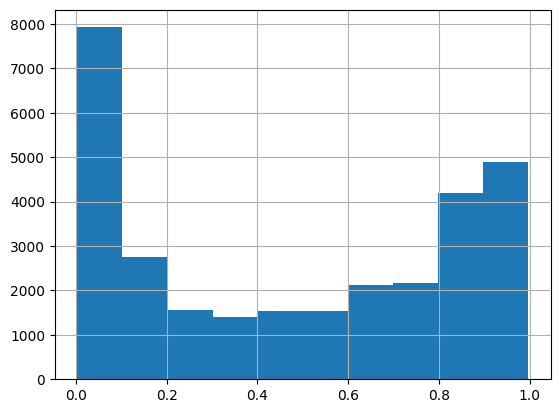

In [180]:
df_iedb_human_preds["model_pred_hum"].hist();

In [181]:
# "E:\Stuff\Research\datasets\New Protein-Virus anom project\iedb_vir_epitopes.csv.zip.csv"
df_iedb_vir = pd.read_csv("iedb_vir_epitopes.csv",compression="zip").drop_duplicates(subset=["Epitopes - Epitope"])
## raw - 138K seqs
print(df_iedb_vir.nunique())
# df_iedb_vir

df_iedb_vir = df_iedb_vir.loc[df_iedb_vir[['Epitopes - # References','Epitopes - # Assays']].max(axis=1)>1]
print(df_iedb_vir.shape[0])
df_iedb_vir = df_iedb_vir.loc[~df_iedb_vir["Epitopes - Epitope"].str.contains("[\+ ]")]
print(df_iedb_human.shape[0])

Epitopes - IEDB ID         138074
Epitopes - Epitope         138074
Epitopes - Antigen            844
Epitopes - Organism           182
Epitopes - # References        59
Epitopes - # Assays           103
dtype: int64
58544
416466


In [182]:
df_iedb_vir_preds = get_escaper_scores(df_iedb_vir.sample(30_183).copy(),trained_model=model,base_model=base_model,seqColName="Epitopes - Epitope",truncate_cao=False)
df_iedb_vir_preds

       Epitopes - IEDB ID  Epitopes - # References  Epitopes - # Assays  \
count           30183.000                30183.000            30183.000   
mean          1018118.714                    1.738                3.744   
std            735213.523                    3.167                6.711   
min                24.000                    1.000                2.000   
25%            127000.500                    1.000                2.000   
50%           1421471.000                    1.000                2.000   
75%           1638845.500                    2.000                4.000   
max           2253121.000                  252.000              602.000   

       base_pred_vir  model_pred_vir  model_pred_hum  model_pred_hum_delta  
count      30183.000       30183.000       30183.000             30183.000  
mean           0.519           0.579           0.421                 0.417  
std            0.004           0.350           0.350                 0.350  
min            0

,Epitopes - IEDB ID,Epitopes - # References,Epitopes - # Assays,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
Epitopes - IEDB ID,1.000,-0.206,-0.201,0.014,-0.070,0.070,0.070
Epitopes - # References,-0.206,1.000,0.839,-0.007,-0.008,0.008,0.008
Epitopes - # Assays,-0.201,0.839,1.000,-0.020,0.015,-0.015,-0.015
base_pred_vir,0.014,-0.007,-0.020,1.000,0.033,-0.033,-0.033
model_pred_vir,-0.070,-0.008,0.015,0.033,1.000,-1.000,-1.000
model_pred_hum,0.070,0.008,-0.015,-0.033,-1.000,1.000,1.000
model_pred_hum_delta,0.070,0.008,-0.015,-0.033,-1.000,1.000,1.000


,Epitopes - IEDB ID,Epitopes - Epitope,Epitopes - Antigen,Epitopes - Organism,Epitopes - # References,Epitopes - # Assays,base_pred_vir,model_pred_vir,model_pred_hum,model_pred_hum_delta
98018,1542217,QVVDADSKIVQLSEI,Replicase polyprotein 1ab,SARS-CoV2,3,6,0.520923,0.832237,0.167763,0.1640
7313,34144,KVNSTLEQY,Replicase polyprotein 1ab,SARS-CoV1,1,4,0.520588,0.878314,0.121686,0.1179
102134,1638757,KKEISNMLSIINKRK,Genome polyprotein,NaN,1,3,0.516382,0.995866,0.004134,0.0003
23953,92534,EEVPNIIHEA,Pre-glycoprotein polyprotein GP complex,Mammarenavirus brazilense (Brazilian mammarena...,1,2,0.525430,0.990064,0.009936,0.0061
64442,1425395,DVVSIRSSNQGN,Non-structural protein ORF4b,Middle East respiratory syndrome-related coron...,1,2,0.523968,0.879147,0.120853,0.1171
...,...,...,...,...,...,...,...,...,...,...
23228,91531,ITAASLPKT,NaN,NaN,1,8,0.522537,0.234407,0.765593,0.7618
92519,1526087,VLPFEDLTKCRT,Replicase polyprotein 1ab,Middle East respiratory syndrome-related coron...,1,2,0.519278,0.687420,0.312580,0.3088
57886,1407622,ADSPSDCSSTSD,Spike glycoprotein,Middle East respiratory syndrome-related coron...,1,2,0.517419,0.459652,0.540348,0.5365
57308,1406731,AALNSEKRPDHV,Replicase polyprotein 1ab,Middle East respiratory syndrome-related coron...,1,2,0.523786,0.112795,0.887205,0.8834


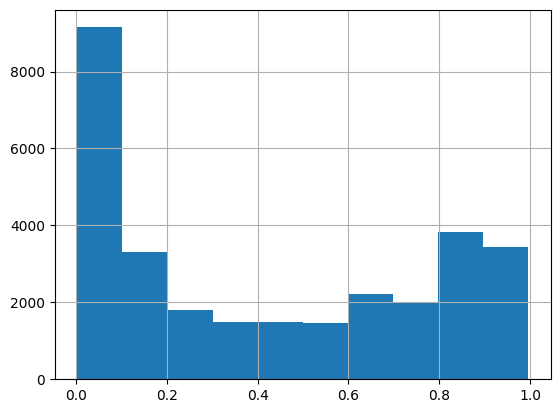

In [183]:
df_iedb_vir_preds["model_pred_hum"].hist();

In [184]:
df_iedb_vir_preds["label"]="vir"
df_iedb_human_preds["label"]="hum"

In [185]:
df_iedbs = pd.concat([df_iedb_vir_preds[["label","model_pred_hum"]],df_iedb_human_preds[["label","model_pred_hum"]]])
df_iedbs

,label,model_pred_hum
98018,vir,0.167763
7313,vir,0.121686
102134,vir,0.004134
23953,vir,0.009936
64442,vir,0.120853
...,...,...
614473,hum,0.896976
245526,hum,0.908618
305206,hum,0.677474
49610,hum,0.852445


<Axes: xlabel='model_pred_hum', ylabel='Density'>

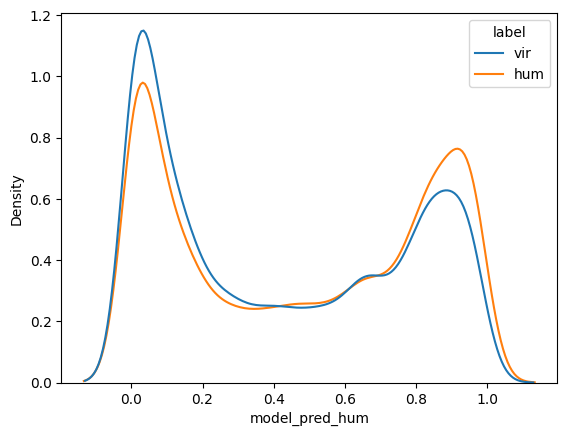

In [186]:
import seaborn as sns
# https://stackoverflow.com/questions/28293028/plotting-grouped-data-in-same-plot-using-pandas
# df_iedbs.groupby(["label"]).plot(kind='kde', ax=plt.gca())

sns.kdeplot(data=df_iedbs, x="model_pred_hum", hue="label")#, bw_adjust=1, cut=1)

In [187]:
df_iedbs.groupby("label").describe().round(2)

model_pred_hum                                        
               count  mean   std  min   25%   50%   75%  max
label                                                       
hum          30123.0  0.48  0.36  0.0  0.09  0.49  0.84  1.0
vir          30183.0  0.42  0.35  0.0  0.07  0.36  0.79  1.0

* a very few epitopes overlap

In [188]:
df_iedb_human.loc[df_iedb_human["Epitopes - Epitope"].isin(df_iedb_vir["Epitopes - Epitope"])]

,Epitopes - IEDB ID,Epitopes - Epitope,Epitopes - Antigen,Epitopes - Organism,Epitopes - # References,Epitopes - # Assays
1408,56462,RVYNNTARY,Ribonucleoside-diphosphate reductase large sub...,Homo sapiens (human),10,10
1739,69921,VMAPRTLIL,HLA-C*12:02 chain,NaN,53,200
1740,69922,VMAPRTLVL,HLA-A*02:01 chain,NaN,59,177
2074,95972,VMAPRTVLL,HLA class I antigen,Homo sapiens (human),62,171
2215,101382,VMAPRTLLL,"HLA class I histocompatibility antigen, A alph...",Homo sapiens (human),66,201
16722,179983,FLQFKTWWI,NaN,NaN,1,13
16996,188740,RPIGIGVQGL,Ribonucleoside-diphosphate reductase large sub...,Homo sapiens (human),12,12
280380,769789,VMAPRSLIL,HLA class I histocompatibility antigen,Homo sapiens (human),1,2


In [189]:
df_iedb_vir.loc[df_iedb_vir["Epitopes - Epitope"].isin(df_iedb_human["Epitopes - Epitope"])]

,Epitopes - IEDB ID,Epitopes - Epitope,Epitopes - Antigen,Epitopes - Organism,Epitopes - # References,Epitopes - # Assays
12449,56462,RVYNNTARY,Ribonucleoside-diphosphate reductase large sub...,Vaccinia virus (vaccinia virus VV),3,5
15513,69921,VMAPRTLIL,Protein UL40,Human herpesvirus 5 (Human cytomegalovirus),11,33
15514,69922,VMAPRTLVL,Protein UL40,Human herpesvirus 5 (Human cytomegalovirus),4,8
25023,95972,VMAPRTVLL,Protein UL40,Human herpesvirus 5 (Human cytomegalovirus),1,3
25587,101382,VMAPRTLLL,Protein UL40,Human herpesvirus 5 (Human cytomegalovirus),5,10
30857,179983,FLQFKTWWI,Gag protein,Human endogenous retrovirus K (HERV-K provirus),1,7
35083,188740,RPIGIGVQGL,Ribonucleoside-diphosphate reductase large sub...,Vaccinia virus (vaccinia virus VV),3,3
45082,769789,VMAPRSLIL,Protein UL40,Human herpesvirus 5 (Human cytomegalovirus),1,3


In [190]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(df_iedbs["model_pred_hum"].values.reshape(-1, 1),df_iedbs["label"])
print(classification_report(df_iedbs["label"],clf.predict(df_iedbs["model_pred_hum"].values.reshape(-1, 1))))
print(roc_auc_score(df_iedbs["label"],clf.predict_proba(df_iedbs["model_pred_hum"].values.reshape(-1, 1))[:,1]))
 

              precision    recall  f1-score   support

         hum       0.53      0.52      0.53     30123
         vir       0.53      0.55      0.54     30183

    accuracy                           0.53     60306
   macro avg       0.53      0.53      0.53     60306
weighted avg       0.53      0.53      0.53     60306

0.5449644981127081
